In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from tqdm import tqdm
#import warnings
#warnings.filterwarnings("ignore")
import json

#### Import datasets

Marionette strains.

In [5]:
fluos = pd.read_csv('datasets/marionette_fluo.csv', index_col='time')
ods = pd.read_csv('datasets/marionette_od.csv', index_col='time')
fluos.shape, ods.shape

((73, 48), (73, 48))

In [6]:
gates = list(set([i[:-3] for i in fluos.columns.tolist()]))
gates

['e34x30MjaKlbA',
 'e16x33NrdA2',
 'e42x32STIMPDH1',
 'e11x32STPhoRadA',
 'e41x32NrdJ1',
 'e15x32NpuSspS2',
 'e32x30SspGyrB',
 'negative_control',
 'positive_control',
 'e20x32gp411',
 'blank',
 'e38x32gp418']

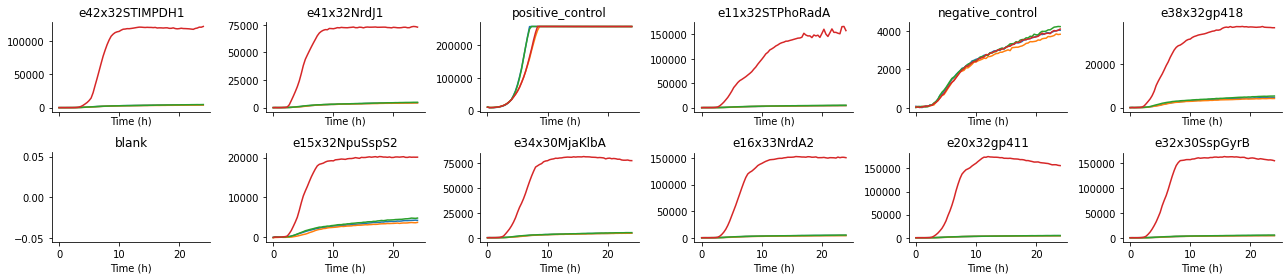

In [4]:
def plot_data(data, cols, num_row, num_col, show_all=True):
    
    idx = 4 if show_all else 3
    
    f, axs = plt.subplots(num_row, num_col, sharex=True, sharey=False, figsize=(num_col*3, num_row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(cols):
            ax.plot(data.index/60, data.loc[:, data.columns.str.startswith(cols[i])].iloc[:,:idx])
            ax.set_title(cols[i])
            ax.set_xlabel('Time (h)')
        else:
            ax.set_visible(False)
    plt.tight_layout()
    sns.despine()
    
plot_data(fluos, gates, 2, 6)

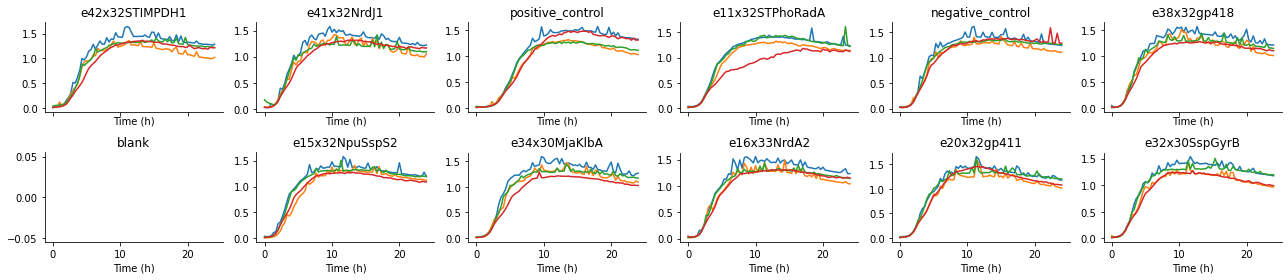

In [5]:
plot_data(ods, gates, 2, 6)

#### ODE Models

In [7]:
#static model
def hill_equation(x, K, n):
    return x**n / (K**n + x**n)

def growth_rate(t, OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

#growth curve
def od_wrapper(t, r, c, c0):

    def od_model(OD, t, r, c):
        dOD = growth_rate(t, OD[0], r, c) * OD[0]
        return dOD
    
    od_sol = odeint(od_model, c0, t, (r, c))
    return np.array(od_sol[:,0])

#model with auto-fluorescence term
def gate_wrapper_complete(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, a, K, n, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, Auto, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - (deg + gamma) * ECFn
        dECFc = bc + syn_ECFc * ind2 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = bg + syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP
        dAuto = a - gamma * Auto

        return [dECFn, dECFc, dECF, dGFP, dAuto, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#model without auto-fluorescence term
def gate_wrapper(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - (deg + gamma) * ECFn
        dECFc = bc + syn_ECFc * ind2 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = bg + syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP

        return [dECFn, dECFc, dECF, dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#model only auto-fluorescence term
def gate_wrapper_auto(t, a, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        Auto, OD = y
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dAuto = a - gamma * Auto
        return [dAuto, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

def gate_wrapper_gfp(t, syn_GFP, deg_GFP, extra, y0):
    
    def gate_model(y, t):
        
        GFP, OD = y
        alpha, beta = extra
        
        gamma = growth_rate(t, OD, alpha, beta)
        dOD = gamma * OD
        dGFP = syn_GFP - (deg_GFP + gamma) * GFP

        return [dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#### Fitting Negative Control for Autofluorescence Term

In [7]:
gate = 'negative_control'
fluo_sel = fluos.loc[:, fluos.columns.str.startswith(gate)]
od_sel = ods.loc[:, ods.columns.str.startswith(gate)]

In [8]:
par = {
    'a': [1e-2, 0, 1e2],
    'alpha': [1e0, 0, 1],
    'beta': [1e0, 0, 2],
    'c0': [1e-2, 0, 0.1]
}
def fit_single_state(gate, fluo, od, ind1, ind2):
    
    num_od_params = 3
    
    def model_fit(t, j):
        fit = gate_wrapper_auto(t, j, ind1, ind2, (o_params[0], o_params[1]), [0, o_params[2]])
        return pd.Series(fit[0])
    
    o_p0 = [i[0] for i in list(par.values())][-num_od_params:]
    o_bounds = [[i[1] for i in list(par.values())][-num_od_params:], [i[2] for i in list(par.values())][-num_od_params:]]
    o_params, o_cov = curve_fit(od_wrapper, od.index, od, bounds=o_bounds)
    
    f_p0 = [i[0] for i in list(par.values())][:-num_od_params]
    f_bounds = [[i[1] for i in list(par.values())][:-num_od_params], [i[2] for i in list(par.values())][:-num_od_params]]
    f_params, f_cov = curve_fit(model_fit, fluo.index, fluo, p0=f_p0, bounds=f_bounds)
    
    f_sim = model_fit(fluo.index, *f_params)
    f_df = pd.DataFrame({'parameter': list(par.keys()), 'value': np.append(f_params, o_params),
                         'error': np.append(np.sqrt(np.diag(f_cov)), np.sqrt(np.diag(o_cov)))})
    f_df.insert(loc=0, column='gate', value=gate)
    
    return f_df, f_sim, fluo.index, fluo

In [9]:
n = 3 #induction state in decimal
f_df, f_sim, f_t, f_data = fit_single_state(gate, fluo_sel.iloc[:,n], od_sel.iloc[:,n], int(n/2), n%2)

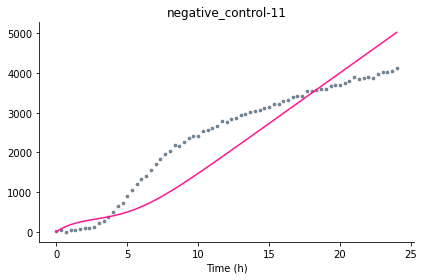

In [10]:
plt.scatter(f_t/60, f_data, c='slategrey', s=7)
plt.plot(f_t/60, f_sim, c='deeppink')
plt.title(gate + '-' + format(n, '02b'))
plt.xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [11]:
def get_params_json(f_df):
    
    f_json = f_df.set_index('gate').apply(dict, axis=1)
    serialized = f_json.groupby(f_json.index).apply(list)
    return serialized.to_json()

get_params_json(f_df)

'{"negative_control":[{"parameter":"a","value":4.2510728086,"error":0.2810351808},{"parameter":"alpha","value":0.0131994739,"error":0.0005813977},{"parameter":"beta","value":1.3400864253,"error":0.007392944},{"parameter":"c0","value":0.0445485604,"error":0.0066062671}]}'

Fitting All States.

In [12]:
par = {
    'a': [1e-2, 0, 1e2],
    'alpha': [1e0, 0, 1],
    'beta': [1e0, 0, 2],
    'c0': [1e-2, 0, 0.1]
}

def fit_all_states(gate, fluo, od):
    
    num_states = 4
    num_od_params = 3
    
    f_t = np.concatenate([fluo.index] * num_states)
    f_data = pd.concat([fluo.iloc[:,i] for i in range(num_states)]) 
    
    o_p0 = [i[0] for i in list(par.values())][-num_od_params:]
    o_bounds = [[i[1] for i in list(par.values())][-num_od_params:], [i[2] for i in list(par.values())][-num_od_params:]]
    
    o_params_all = []
    o_df = pd.DataFrame()
    for i in range(od.shape[1]):
        o_params, o_cov = curve_fit(od_wrapper, od.index, od.iloc[:,i], bounds=o_bounds)
        o_df = o_df.append(pd.DataFrame({'parameter': [j + '_' + '{:02b}'.format(int(i)) for j in list(par.keys())[-num_od_params:]],
                                         'value': o_params, 'error': np.sqrt(np.diag(o_cov))}))
        o_params_all.append(o_params)
    
    f_p0 = [i[0] for i in list(par.values())][:-num_od_params]
    f_bounds = [[i[1] for i in list(par.values())][:-num_od_params], [i[2] for i in list(par.values())][:-num_od_params]]
    
    def model_fit_inner(t, a, ind1, ind2, extra, y0):
        fit = gate_wrapper_auto(t, a, ind1, ind2, extra, y0)
        return pd.Series(fit[0])
    
    def model_fit(t, a):
        result = [model_fit_inner(fluo.index, a, int(n/2), n%2, \
                                   (o_params_all[n][0], o_params_all[n][1]), [0, o_params_all[n][2]]) \
                                   for n in range(num_states)]
        return pd.concat(result)
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=f_p0, bounds=f_bounds)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'parameter': list(par.keys())[:-num_od_params], 'value': f_params, 'error': np.sqrt(np.diag(f_cov))})
    f_df = f_df.append(o_df)
    f_df.insert(loc=0, column='gate', value=gate)
    
    return f_t, f_df.reset_index(drop=True), f_sim, f_data

In [13]:
f_t_res, f_df_res, f_sim_res, f_data_res = fit_all_states(gate, fluo_sel, od_sel)

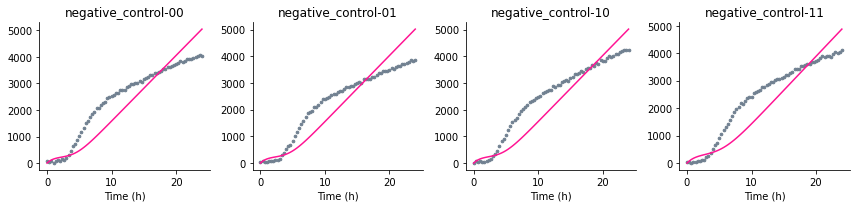

In [14]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t_res[idx*i:idx*(i+1)]/60, f_data_res[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_res[idx*i:idx*(i+1)]/60, f_sim_res[idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [15]:
get_params_json(f_df_res)

'{"negative_control":[{"parameter":"a","value":4.1263866925,"error":0.0548065759},{"parameter":"alpha_00","value":0.0183505942,"error":0.0014720326},{"parameter":"beta_00","value":1.3751877709,"error":0.0113221817},{"parameter":"c0_00","value":0.0259387448,"error":0.0082914205},{"parameter":"alpha_01","value":0.0179616577,"error":0.0013036961},{"parameter":"beta_01","value":1.2331560489,"error":0.009336152},{"parameter":"c0_01","value":0.021976411,"error":0.0064472692},{"parameter":"alpha_10","value":0.0173340277,"error":0.0006321969},{"parameter":"beta_10","value":1.2990970781,"error":0.0050307862},{"parameter":"c0_10","value":0.0271749145,"error":0.0038394764},{"parameter":"alpha_11","value":0.0131994739,"error":0.0005813977},{"parameter":"beta_11","value":1.3400864253,"error":0.007392944},{"parameter":"c0_11","value":0.0445485604,"error":0.0066062671}]}'

#### Fitting Positive Control for GFP Parameters

In [16]:
gate = 'positive_control'
fluo_sel = fluos.loc[:, fluos.columns.str.startswith(gate)]
od_sel = ods.loc[:, ods.columns.str.startswith(gate)]

In [17]:
#objective function
def computeSSE_global(f_p0, f_t, f_data, f_bounds, o_params_all):
    
    num_states = 4
    
    def model_fit_inner(t, syn_GFP, deg_GFP, extra, y0):
        fit = gate_wrapper_gfp(t, syn_GFP, deg_GFP, extra, y0)
        return pd.Series(fit[0])
    
    def model_fit(t, syn_GFP, deg_GFP):
        result = [model_fit_inner(f_t[:int(len(f_t)/num_states)], syn_GFP, deg_GFP, \
                                  (o_params_all[n][0], o_params_all[n][1]), [0, o_params_all[n][2]])\
                                  for n in range(num_states)]
        return pd.concat(result)
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=f_p0, bounds=f_bounds)
    f_sim = model_fit(f_t, *f_params)
    
    error = [(val-sal)**2 for val, sal in zip(f_sim, f_data)]
    
    return sum(error)

#generate random numbers from a uniform distribution for the initial guesses
def randomSearch(iterations, num_params, f_t, f_data, bounds, od_params_all):
    
    initialGuesses = []
    for k in tqdm(range(iterations)):
        
        guess = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE_global(guess, f_t, f_data, bounds, od_params_all)
        initialGuesses.append((error, guess))
    
    sortedGuesses = sorted(initialGuesses)
    bestGuess = sortedGuesses[0][1]
    
    return bestGuess

In [18]:
par = {
    'syn_GFP': [1e4, 0, 1e6],
    'deg_GFP': [1e-3, 0, 1e0],
    'alpha': [1e0, 0, 1],
    'beta': [1e0, 0, 2],
    'c0': [1e-2, 0, 0.1]
}

def fit_all_states(gate, fluo, od):
    
    num_states = 4
    num_od_params = 3
    
    f_t = np.concatenate([fluo.index] * num_states)
    f_data = pd.concat([fluo.iloc[:,i] for i in range(num_states)]) 
    
    o_p0 = [i[0] for i in list(par.values())][-num_od_params:]
    o_bounds = [[i[1] for i in list(par.values())][-num_od_params:], [i[2] for i in list(par.values())][-num_od_params:]]
    
    o_params_all = []
    o_df = pd.DataFrame()
    for i in range(od.shape[1]):
        o_params, o_cov = curve_fit(od_wrapper, od.index, od.iloc[:,i], bounds=o_bounds)
        o_df = o_df.append(pd.DataFrame({'parameter': [j + '_' + '{:02b}'.format(int(i)) for j in list(par.keys())[-num_od_params:]],
                                         'value': o_params, 'error': np.sqrt(np.diag(o_cov))}))
        o_params_all.append(o_params)
    
    #f_p0 = [i[0] for i in list(par.values())][:-num_od_params]
    f_bounds = [[i[1] for i in list(par.values())][:-num_od_params], [i[2] for i in list(par.values())][:-num_od_params]]
    f_p0 = randomSearch(30, len(f_bounds[0]), f_t, f_data, f_bounds, o_params_all)
    
    def model_fit_inner(t, syn_GFP, deg_GFP, extra, y0):
        fit = gate_wrapper_gfp(t, syn_GFP, deg_GFP, extra, y0)
        return pd.Series(fit[0])
    
    def model_fit(t, syn_GFP, deg_GFP):
        result = [model_fit_inner(fluo.index, syn_GFP, deg_GFP, \
                                  (o_params_all[n][0], o_params_all[n][1]), [0, o_params_all[n][2]])\
                                  for n in range(num_states)]
        return pd.concat(result)
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=f_p0, bounds=f_bounds)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'parameter': list(par.keys())[:-num_od_params], 'value': f_params, 'error': np.sqrt(np.diag(f_cov))})
    f_df = f_df.append(o_df)
    f_df.insert(loc=0, column='gate', value=gate)
    
    return f_t, f_df.reset_index(drop=True), f_sim, f_data

In [19]:
f_t_res, f_df_res, f_sim_res, f_data_res = fit_all_states(gate, fluo_sel, od_sel)

100%|██████████| 30/30 [00:19<00:00,  1.55it/s]


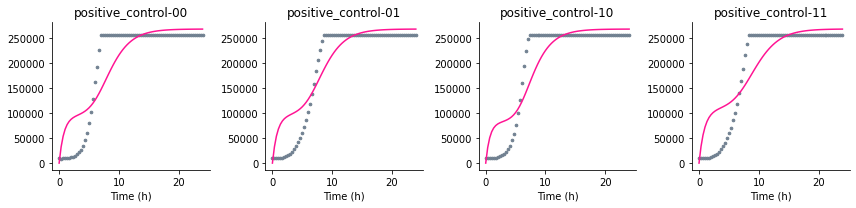

In [20]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t_res[idx*i:idx*(i+1)]/60, f_data_res[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_res[idx*i:idx*(i+1)]/60, f_sim_res[idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [21]:
f_df_res

,gate,parameter,value,error
0,positive_control,syn_GFP,1975.473570,109.368023
1,positive_control,deg_GFP,0.007368,0.000465
2,positive_control,alpha_00,0.013754,0.000651
3,positive_control,beta_00,1.449400,0.008878
4,positive_control,c0_00,0.013443,0.002978
5,positive_control,alpha_01,0.013427,0.001001
6,positive_control,beta_01,1.204001,0.011778
7,positive_control,c0_01,0.012717,0.004314
8,positive_control,alpha_10,0.016852,0.000704
9,positive_control,beta_10,1.218440,0.005792


Does not work well. But for now, I'll just take the deg_GFP value anyway.

#### Fitting a Single Gate (Ignoring Auto-fluorescence)

Select a single gate for the first try.

In [9]:
#sel = 1
#gate = gates[sel]
gate = 'e42x32STIMPDH1'
print(gate)
fluo_sel = fluos.loc[:, fluos.columns.str.startswith(gate)]
od_sel = ods.loc[:, ods.columns.str.startswith(gate)]

e42x32STIMPDH1


Sampling initial guesses.

In [10]:
#objective function
def computeSSE(init_params, f_t, f_data, bounds, od_params, ind1, ind2):
    
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(4), od_params[2]))
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    f_params, _ = curve_fit(model_fit, f_t, f_data, p0=init_params, bounds=bounds)
    solution = model_fit(f_t, *f_params)
    error = [(val-sal)**2 for val, sal in zip(solution, f_data)]
    
    return sum(error)

#generate random numbers from a uniform distribution for the initial guesses
def randomSearch(iterations, num_params, f_t, f_data, bounds, od_params, ind1, ind2):
    
    initialGuesses = []
    for k in tqdm(range(iterations)):
        guess = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE(guess, f_t, f_data, bounds, od_params, ind1, ind2)
        initialGuesses.append((error, guess))
    
    sortedGuesses = sorted(initialGuesses)
    bestGuess = sortedGuesses[0][1]
    
    return bestGuess

In [11]:
par = {
    'bn': [1e-1, 0, 1e1],
    'bc': [1e-1, 0, 1e1],
    'bg': [1e-2, 0, 1e1],
    'syn_ECFn': [4e0, 0, 1e2],
    'syn_ECFc': [4e0, 0, 1e2],
    'syn_ECF': [50e-10, 0, 1e-4],
    'deg': [7e-3, 0, 1e-1],
    'syn_GFP': [1e4, 0, 1e5],
    'deg_GFP': [1e-2, 0, 1e0],
    # 'a': [1e-2, 0, 1e1],
    'K': [1e-1, 0, 1e2],
    'n': [2e0, 0, 4],
    'alpha': [1e0, 0, 1],
    'beta': [1e0, 0, 2],
    'c0': [1e-2, 0, 0.1]
}

def fit_single_state(gate, fluo, od, ind1, ind2, sampled=None):
    
    num_od_params = 3
    num_vars = 4
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, (o_params[0], o_params[1]), pd.Series(np.append(np.zeros(num_vars), o_params[2])))
        return pd.Series(fit[3])
    
    o_p0 = [i[0] for i in list(par.values())][-num_od_params:]
    o_bounds = [[i[1] for i in list(par.values())][-num_od_params:], [i[2] for i in list(par.values())][-num_od_params:]]
    o_params, o_cov = curve_fit(od_wrapper, od.index, od, bounds=o_bounds)
    
    
    f_bounds = [[i[1] for i in list(par.values())][:-num_od_params], [i[2] for i in list(par.values())][:-num_od_params]]
    if sampled is None:
        f_p0 = [i[0] for i in list(par.values())][:-num_od_params]
    else:
        f_p0 = randomSearch(10, len(f_bounds[0]), fluo.index, fluo, f_bounds, o_params, ind1, ind2)
    
    f_params, f_cov = curve_fit(model_fit, fluo.index, fluo, p0=f_p0, bounds=f_bounds)
    
    f_sim = model_fit(fluo.index, *f_params)
    f_df = pd.DataFrame({'parameter': list(par.keys()), 'value': np.append(f_params, o_params),
                         'error': np.append(np.sqrt(np.diag(f_cov)), np.sqrt(np.diag(o_cov)))})
    f_df.insert(loc=0, column='gate', value=gate)
    
    return f_df, f_sim, fluo.index, fluo

In [12]:
n = 3 #induction state in decimal
f_df, f_sim, f_t, f_data = fit_single_state(gate, fluo_sel.iloc[:,n], od_sel.iloc[:,n], int(n/2), n%2, True)

100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


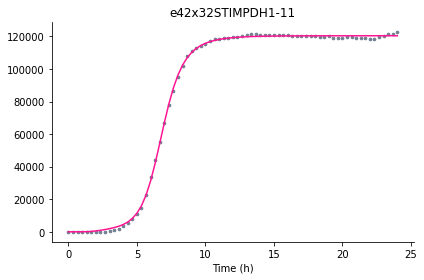

In [13]:
plt.scatter(f_t/60, f_data, c='slategrey', s=7)
plt.plot(f_t/60, f_sim, c='deeppink')
plt.title(gate + '-' + format(n, '02b'))
plt.xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [34]:
f_df['value'].tolist(), [i*10 for i in f_df['value'].tolist()]

([1.1078917759218299,
  4.724676180009719,
  3.5561330199860692,
  30.757797001953033,
  41.54736185284504,
  2.884772561136935e-07,
  0.01296228001235837,
  64382.936784585196,
  0.5244454524554244,
  71.91050793385232,
  3.9404093112112593,
  0.013172833126152748,
  1.2786537224078383,
  0.027517403123789336],
 [11.0789177592183,
  47.24676180009719,
  35.56133019986069,
  307.5779700195303,
  415.4736185284504,
  2.8847725611369354e-06,
  0.12962280012358368,
  643829.3678458519,
  5.244454524554244,
  719.1050793385232,
  39.40409311211259,
  0.13172833126152747,
  12.786537224078383,
  0.27517403123789336])

In [1]:
print('{}'.format(2))

2


In [14]:
for i, row in f_df.iterrows():
    print('theta[{}] ~ uniform({}, {})'.format(i+1, row['value'], row['error']))

theta[1] ~ uniform(2.5803757852007854, 0.02652738849471484)
theta[2] ~ uniform(8.373392121737158, 0.13965739330887758)
theta[3] ~ uniform(5.827417093059297, 0.24023801463248518)
theta[4] ~ uniform(66.60158634533356, 0.4162774181279974)
theta[5] ~ uniform(50.38818845005642, 1.0245339749021294)
theta[6] ~ uniform(6.703078186470548e-08, 9.538974590242948e-09)
theta[7] ~ uniform(0.01320520158840341, 0.0017495625191441414)
theta[8] ~ uniform(30541.09509595857, 695.2992643474972)
theta[9] ~ uniform(0.24897005451979845, 0.004793954799751722)
theta[10] ~ uniform(43.886173583300305, 9.349782990938287)
theta[11] ~ uniform(3.9844049354107764, 0.5391252910520072)
theta[12] ~ uniform(0.013172833126152748, 0.0005729113926027217)
theta[13] ~ uniform(1.2786537224078383, 0.0071522006686147895)
theta[14] ~ uniform(0.027517403123789336, 0.004570480290994749)


In [ ]:
get_params_json(f_df)

#### Fitting All Gates

In [ ]:
real_gates = [i for i in gates if i not in ['positive_control', 'negative_control', 'blank']]

In [ ]:
fluo_sels_arr = []
od_sels_arr = []
for gate in real_gates:
    fluo_sel = fluos.loc[:, fluos.columns.str.startswith(gate)].iloc[:,3]
    od_sel = ods.loc[:, ods.columns.str.startswith(gate)].iloc[:,3]
    fluo_sels_arr.append(fluo_sel)
    od_sels_arr.append(od_sel)
fluo_sels = pd.concat(fluo_sels_arr, axis=1)
od_sels = pd.concat(od_sels_arr, axis=1)

In [ ]:
#objective function
def computeSSE_global(f_p0, f_t, f_data, f_bounds, o_params_all):
    
    num_states = 9
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    def model_fit(t, f0, f1, f2, f3, f4, f5, f6, f7, f8,
                 h0, h1, h2, h3, h4, h5, h6, h7, h8):
        aa = [2 for i in range(9)] #aa = [a0, a1, a2, a3, a4, a5, a6, a7, a8]
        bb = [2 for i in range(9)]#bb = [b0, b1, b2, b3, b4, b5, b6, b7, b8]
        c = 2
        dd = [50 for i in range(9)]#dd = [d0, d1, d2, d3, d4, d5, d6, d7, d8]
        ee = [50 for i in range(9)]#ee = [e0, e1, e2, e3, e4, e5, e6, e7, e8]
        ff = [f0, f1, f2, f3, f4, f5, f6, f7, f8]
        gg = [0.05 for i in range(9)]#gg = [g0, g1, g2, g3, g4, g5, g6, g7, g8]
        hh = [h0, h1, h2, h3, h4, h5, h6, h7, h8]
        i = 0.05
        jj = [20 for i in range(9)]#jj = [j0, j1, j2, j3, j4, j5, j6, j7, j8]
        kk = [4 for i in range(9)]#kk = [k0, k1, k2, k3, k4, k5, k6, k7, k8]
        result = [model_fit_inner(f_t[:int(len(f_t)/num_states)], aa[n], bb[n], c, dd[n], ee[n], ff[n], gg[n], hh[n], i, jj[n], kk[n], 1, 1, \
                                   (o_params_all[n][0], o_params_all[n][1]), [0, 0, 0, 0, o_params_all[n][2]]) \
                                   for n in range(num_states)]
        return pd.concat(result)
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=f_p0, bounds=f_bounds)
    f_sim = model_fit(f_t, *f_params)
    
    error = [(val-sal)**2 for val, sal in zip(f_sim, f_data)]
    
    return sum(error)

#generate random numbers from a uniform distribution for the initial guesses
def randomSearch(iterations, num_params, f_t, f_data, bounds, od_params_all):
    
    initialGuesses = []
    for k in tqdm(range(iterations)):
        
        guess = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE_global(guess, f_t, f_data, bounds, od_params_all)
        initialGuesses.append((error, guess))
    
    sortedGuesses = sorted(initialGuesses)
    bestGuess = sortedGuesses[0][1]
    
    return bestGuess

In [ ]:
par = {
    #'bn0': [1e-1, 0, 1e1], #a
    #'bn1': [1e-1, 0, 1e1], #a
    #'bn2': [1e-1, 0, 1e1], #a
    #'bn3': [1e-1, 0, 1e1], #a
    #'bn4': [1e-1, 0, 1e1], #a
    #'bn5': [1e-1, 0, 1e1], #a
    #'bn6': [1e-1, 0, 1e1], #a
    #'bn7': [1e-1, 0, 1e1], #a
    #'bn8': [1e-1, 0, 1e1], #a
    #'bc0': [1e-1, 0, 1e1], #b
    #'bc1': [1e-1, 0, 1e1], #b
    #'bc2': [1e-1, 0, 1e1], #b
    #'bc3': [1e-1, 0, 1e1], #b
    #'bc4': [1e-1, 0, 1e1], #b
    #'bc5': [1e-1, 0, 1e1], #b
    #'bc6': [1e-1, 0, 1e1], #b
    #'bc7': [1e-1, 0, 1e1], #b
    #'bc8': [1e-1, 0, 1e1], #b
    #'bg': [1e-2, 0, 1e1], #c - shared
    #'syn_ECFn0': [4e0, 0, 1e2], #d
    #'syn_ECFn1': [4e0, 0, 1e2], #d
    #'syn_ECFn2': [4e0, 0, 1e2], #d
    #'syn_ECFn3': [4e0, 0, 1e2], #d
    #'syn_ECFn4': [4e0, 0, 1e2], #d
    #'syn_ECFn5': [4e0, 0, 1e2], #d
    #'syn_ECFn6': [4e0, 0, 1e2], #d
    #'syn_ECFn7': [4e0, 0, 1e2], #d
    #'syn_ECFn8': [4e0, 0, 1e2], #d
    #'syn_ECFc0': [4e0, 0, 1e2], #e
    #'syn_ECFc1': [4e0, 0, 1e2], #e
    #'syn_ECFc2': [4e0, 0, 1e2], #e
    #'syn_ECFc3': [4e0, 0, 1e2], #e
    #'syn_ECFc4': [4e0, 0, 1e2], #e
    #'syn_ECFc5': [4e0, 0, 1e2], #e
    #'syn_ECFc6': [4e0, 0, 1e2], #e
    #'syn_ECFc7': [4e0, 0, 1e2], #e
    #'syn_ECFc8': [4e0, 0, 1e2], #e
    'syn_ECF0': [50e-10, 0, 1e-4], #f
    'syn_ECF1': [50e-10, 0, 1e-4], #f
    'syn_ECF2': [50e-10, 0, 1e-4], #f
    'syn_ECF3': [50e-10, 0, 1e-4], #f
    'syn_ECF4': [50e-10, 0, 1e-4], #f
    'syn_ECF5': [50e-10, 0, 1e-4], #f
    'syn_ECF6': [50e-10, 0, 1e-4], #f
    'syn_ECF7': [50e-10, 0, 1e-4], #f
    'syn_ECF8': [50e-10, 0, 1e-4], #f
    #'deg0': [7e-3, 0, 1e-1], #g
    #'deg1': [7e-3, 0, 1e-1], #g
    #'deg2': [7e-3, 0, 1e-1], #g
    #'deg3': [7e-3, 0, 1e-1], #g
    #'deg4': [7e-3, 0, 1e-1], #g
    #'deg5': [7e-3, 0, 1e-1], #g
    #'deg6': [7e-3, 0, 1e-1], #g
    #'deg7': [7e-3, 0, 1e-1], #g
    #'deg8': [7e-3, 0, 1e-1], #g
    'syn_GFP0': [1e4, 0, 1e5], #h
    'syn_GFP1': [1e4, 0, 1e5], #h
    'syn_GFP2': [1e4, 0, 1e5], #h
    'syn_GFP3': [1e4, 0, 1e5], #h
    'syn_GFP4': [1e4, 0, 1e5], #h
    'syn_GFP5': [1e4, 0, 1e5], #h
    'syn_GFP6': [1e4, 0, 1e5], #h
    'syn_GFP7': [1e4, 0, 1e5], #h
    'syn_GFP8': [1e4, 0, 1e5], #h
    #'deg_GFP': [1e-2, 0, 1e0], #i - shared
    # 'a': [1e-2, 0, 1e1],
    #'K0': [1e-1, 0, 1e2], #j
    #'K1': [1e-1, 0, 1e2], #j
    #'K2': [1e-1, 0, 1e2], #j
    #'K3': [1e-1, 0, 1e2], #j
    #'K4': [1e-1, 0, 1e2], #j
    #'K5': [1e-1, 0, 1e2], #j
    #'K6': [1e-1, 0, 1e2], #j
    #'K7': [1e-1, 0, 1e2], #j
    #'K8': [1e-1, 0, 1e2], #j
    #'n0': [2e0, 0, 4], #k
    #'n1': [2e0, 0, 4], #k
    #'n2': [2e0, 0, 4], #k
    #'n3': [2e0, 0, 4], #k
    #'n4': [2e0, 0, 4], #k
    #'n5': [2e0, 0, 4], #k
    #'n6': [2e0, 0, 4], #k
    #'n7': [2e0, 0, 4], #k
    #'n8': [2e0, 0, 4], #k
    'alpha': [1e0, 0, 1],
    'beta': [1e0, 0, 2],
    'c0': [1e-2, 0, 0.1]
}

def fit_all_states(fluo, od):
    
    num_states = 9
    num_od_params = 3
    
    f_t = np.concatenate([fluo.index] * num_states)
    f_data = pd.concat([fluo.iloc[:,i] for i in range(num_states)]) 
    
    o_p0 = [i[0] for i in list(par.values())][-num_od_params:]
    o_bounds = [[i[1] for i in list(par.values())][-num_od_params:], [i[2] for i in list(par.values())][-num_od_params:]]
    
    o_params_all = []
    o_df = pd.DataFrame()
    for i in range(od.shape[1]):
        o_params, o_cov = curve_fit(od_wrapper, od.index, od.iloc[:,i], bounds=o_bounds)
        #o_df = o_df.append(pd.DataFrame({'value': o_params, 'error': np.sqrt(np.diag(o_cov))}))
        o_df = o_df.append(pd.DataFrame({'parameter': [j + '_' + str(i) for j in list(par.keys())[-num_od_params:]],
                                         'value': o_params, 'error': np.sqrt(np.diag(o_cov))}))
        o_params_all.append(o_params)
    
    #f_p0 = [i[0] for i in list(par.values())][:-num_od_params]
    f_bounds = [[i[1] for i in list(par.values())][:-num_od_params], [i[2] for i in list(par.values())][:-num_od_params]]
    f_p0 = randomSearch(20, len(f_bounds[0]), f_t, f_data, f_bounds, o_params_all)
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    #def model_fit(t, c, i, a0, a1, a2, a3, a4, a5, a6, a7, a8, b0, b1, b2, b3, b4, b5, b6, b7, b8, d0, d1, d2, d3, d4, d5, d6, d7, d8,
    #             e0, e1, e2, e3, e4, e5, e6, e7, e8, f0, f1, f2, f3, f4, f5, f6, f7, f8, g0, g1, g2, g3, g4, g5, g6, g7, g8,
    #             h0, h1, h2, h3, h4, h5, h6, h7, h8, j0, j1, j2, j3, j4, j5, j6, j7, j8, k0, k1, k2, k3, k4, k5, k6, k7, k8):
    
    def model_fit(t, f0, f1, f2, f3, f4, f5, f6, f7, f8,
                 h0, h1, h2, h3, h4, h5, h6, h7, h8):
        aa = [2 for i in range(9)] #aa = [a0, a1, a2, a3, a4, a5, a6, a7, a8]
        bb = [2 for i in range(9)]#bb = [b0, b1, b2, b3, b4, b5, b6, b7, b8]
        c = 2
        dd = [50 for i in range(9)]#dd = [d0, d1, d2, d3, d4, d5, d6, d7, d8]
        ee = [50 for i in range(9)]#ee = [e0, e1, e2, e3, e4, e5, e6, e7, e8]
        ff = [f0, f1, f2, f3, f4, f5, f6, f7, f8]
        gg = [0.05 for i in range(9)]#gg = [g0, g1, g2, g3, g4, g5, g6, g7, g8]
        hh = [h0, h1, h2, h3, h4, h5, h6, h7, h8]
        i = 0.05
        jj = [20 for i in range(9)]#jj = [j0, j1, j2, j3, j4, j5, j6, j7, j8]
        kk = [4 for i in range(9)]#kk = [k0, k1, k2, k3, k4, k5, k6, k7, k8]
        result = [model_fit_inner(fluo.index, aa[n], bb[n], c, dd[n], ee[n], ff[n], gg[n], hh[n], i, jj[n], kk[n], 1, 1, \
                                   (o_params_all[n][0], o_params_all[n][1]), [0, 0, 0, 0, o_params_all[n][2]]) \
                                   for n in range(num_states)]
        return pd.concat(result)
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=f_p0, bounds=f_bounds)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'parameter': list(par.keys())[:-num_od_params], 'value': f_params, 'error': np.sqrt(np.diag(f_cov))})
    #f_df = pd.DataFrame({'value': f_params, 'error': np.sqrt(np.diag(f_cov))})
    
    f_df = f_df.append(o_df)
    #f_df.insert(loc=0, column='gate', value=gate)
    
    return f_t, f_df.reset_index(drop=True), f_sim, f_data

In [ ]:
f_t_all, f_df_all, f_sim_all, f_data_all = fit_all_states(fluo_sels, od_sels)

In [ ]:
f, axs = plt.subplots(3, 3, sharex=True, sharey=False, figsize=(12, 5))
axr = axs.ravel()
cols = fluo_sels.columns.tolist()
idx = len(fluo_sels)
for i, ax in enumerate(axr):
    ax.scatter(f_t_all[idx*i:idx*(i+1)]/60, f_data_all[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_all[idx*i:idx*(i+1)]/60, f_sim_all[idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(cols[i])
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(3, 3, sharex=True, sharey=False, figsize=(12, 5))
axr = axs.ravel()
cols = fluo_sels.columns.tolist()
idx = len(fluo_sels)
for i, ax in enumerate(axr):
    ax.scatter(f_t_all[idx*i:idx*(i+1)]/60, f_data_all[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_all[idx*i:idx*(i+1)]/60, f_sim_all[idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(cols[i])
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(3, 3, sharex=True, sharey=False, figsize=(12, 5))
axr = axs.ravel()
cols = fluo_sels.columns.tolist()
idx = len(fluo_sels)
for i, ax in enumerate(axr):
    ax.scatter(f_t_all[idx*i:idx*(i+1)]/60, f_data_all[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_all[idx*i:idx*(i+1)]/60, f_sim_all[idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(cols[i])
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
f_df_all

#### Parameters Analysis

In [ ]:
bg = f_df_all[f_df_all['parameter'].isin(['bg'])]
bg = bg.loc[bg.index.repeat(9)]
deg_gfp = f_df_all[f_df_all['parameter'].isin(['deg_GFP'])]
deg_gfp = deg_gfp.loc[deg_gfp.index.repeat(9)]

In [ ]:
datas = [
    #f_df_all[f_df_all['parameter'].isin(['bn0', 'bn1', 'bn2', 'bn3', 'bn4', 'bn5', 'bn6', 'bn7', 'bn8'])],
    #f_df_all[f_df_all['parameter'].isin(['bc0', 'bc1', 'bc2', 'bc3', 'bc4', 'bc5', 'bc6', 'bc7', 'bc8'])],
    #f_df_all[f_df_all['parameter'].isin(['syn_ECFn0', 'syn_ECFn1', 'syn_ECFn2', 'syn_ECFn3', 'syn_ECFn4', 'syn_ECFn5', 'syn_ECFn6', 'syn_ECFn7', 'syn_ECFn8'])],
    #f_df_all[f_df_all['parameter'].isin(['syn_ECFc0', 'syn_ECFc1', 'syn_ECFc2', 'syn_ECFc3', 'syn_ECFc4', 'syn_ECFc5', 'syn_ECFc6', 'syn_ECFc7', 'syn_ECFc8'])],
    f_df_all[f_df_all['parameter'].isin(['syn_ECF0', 'syn_ECF1', 'syn_ECF2', 'syn_ECF3', 'syn_ECF4', 'syn_ECF5', 'syn_ECF6', 'syn_ECF7', 'syn_ECF8'])],
    #f_df_all[f_df_all['parameter'].isin(['deg0', 'deg1', 'deg2', 'deg3', 'deg4', 'deg5', 'deg6', 'deg7', 'deg8'])],
    f_df_all[f_df_all['parameter'].isin(['syn_GFP0', 'syn_GFP1', 'syn_GFP2', 'syn_GFP3', 'syn_GFP4', 'syn_GFP5', 'syn_GFP6', 'syn_GFP7', 'syn_GFP8'])],
    #bg,
    #deg_gfp,
    #f_df_all[f_df_all['parameter'].isin(['K0', 'K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8'])],
    #f_df_all[f_df_all['parameter'].isin(['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8'])],
]
#titles = ['bn', 'bc', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'bg', 'deg_GFP', 'K', 'n']
titles = ['syn_ECF', 'syn_GFP']
    
f, axs = plt.subplots(1, 2, sharex=True, figsize=(16, 4))
for i, ax in enumerate(axs.ravel()):
    if i < len(datas):
        data = datas[i].reset_index(drop=True)
        ax.scatter(real_gates, data['value'])
        ax.set_title(titles[i])
    else:
        ax.set_visible(False)
    ax.set_xticklabels(real_gates, rotation=90)
sns.despine()
plt.tight_layout()

#### Simulating Fixed Parameters

In [ ]:
#just to simulate parameters without fitting
def simulate_single_state(fluo, od_params, par, ind1, ind2):
    
    parameters = list(par.keys())
    f_t = fluo.index
    f_data = fluo.copy()
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(5), od_params[2]))
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k, l):
        fit = gate_wrapper_complete(t, a, b, c, d, e, f, g, h, i, j, k, l, ind1, ind2, extra, y0)
        return pd.Series(fit[3]) + pd.Series(fit[4])
    
    f_params = list(par.values())
    f_sim = model_fit(f_t, *f_params)
    return f_sim, f_t, f_data

In [ ]:
f, axs = plt.subplots(1, 4, figsize=(14, 2), sharey=False)
for i in range(0, 5):
    par = {
        'bn': 1 * 10**-1,
        'bc': 1 * 10**-1,
        'bg': 1 * 10**-2,
        'syn_ECFn': 4 * 10**0,
        'syn_ECFc': 4 * 10**0,
        'syn_ECF': 50 * 10**-10,
        'deg': 7 * 10**-3,
        'syn_GFP': 1 * 10**i,
        'deg_GFP': 1 * 10**-2,
        'a': 1 * 10**-2,
        'K': 1 * 10**-1,
        'n': 2 * 10**0
    }
    for n in range(4):
        f_sim_sin, f_t_sin, f_data_sin = simulate_single_state(fluo_sel.iloc[:,n], od_params_sel[n], par, int(n/2), n%2)
        axs[n].plot(f_t_sin/60, f_sim_sin, label=i)
        axs[n].legend()
        axs[n].set_title(gate)
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()

In [ ]:
par = {
    'bn': 1 * 10**-1,
    'bc': 1 * 10**-1,
    'bg': 1 * 10**-2,
    'syn_ECFn': 4 * 10**0,
    'syn_ECFc': 4 * 10**0,
    'syn_ECF': 50 * 10**-10,
    'deg': 7 * 10**-3,
    'syn_GFP': 1 * 10**4,
    'deg_GFP': 1 * 10**-2,
    'a': 1 * 10**-2,
    'K': 1 * 10**-1,
    'n': 2 * 10**0
}

def fit_all_states(fluo, od_params):
    
    num_states = 4
    num_vars = 5
    
    title = fluo.columns.tolist()[0] #take the first entry only because they are all the same
    f_t = np.concatenate([fluo.index] * num_states)
    f_data = pd.concat([fluo.iloc[:,i] for i in range(num_states)]) 
    y0 = pd.concat([pd.Series(np.append(np.zeros(num_vars), od_params[i][2])) for i in range(num_states)])
    
    #gate_bounds = [lower_bounds, upper_bounds]
    #init_guesses = randomSearch_global(10, len(parameters), f_t, f_data, gate_bounds, od_params)
    
    parameters = list(par.keys())
    init_guesses = list(par.values())
    lower_bounds = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    upper_bounds = [1e1, 1e1, 1e1, 1e2, 1e2, 1e-4, 1e-1, 1e5, 1e0, 1e1, 1e2, 4]
    gate_bounds = [lower_bounds, upper_bounds]
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, l, ind1, ind2, extra, y0):
        fit = gate_wrapper_complete(t, a, b, c, d, e, f, g, h, i, j, k, l, ind1, ind2, extra, y0)
        return pd.Series(fit[3]) + pd.Series(fit[4])
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k, l):
        result = [model_fit_inner(fluo.index, a, b, c, d, e, f, g, h, i, j, k, l, int(n/2), n%2, \
                                   (od_params[n][0], od_params[n][1]), np.append(np.zeros(num_vars), od_params[n][2])) \
                                   for n in range(num_states)]
        return pd.concat(result)
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses, bounds=gate_bounds)#, method='dogbox')
    #f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_t, f_data

In [ ]:
f_df_res, f_sim_res, f_t_res, f_data_res = fit_all_states(fluo_sel, od_params_sel)

In [ ]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t_res[idx*i:idx*(i+1)]/60, f_data_res[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_res[idx*i:idx*(i+1)]/60, f_sim_res[idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
plt.errorbar(f_df_res['Parameters'], f_df_res['Value'], f_df_res['Err'], fmt='.')
plt.xticks(rotation=90)
plt.show()